In [1]:
import sys
from pathlib import Path

current_dir = Path().resolve()
parent_dir = current_dir.parent
sys.path.insert(0, str(parent_dir))

# from model.kalman_heston_filter import *
# from model.kalman_heston import *
from model.Heston import *
from model.heston_kf import *
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

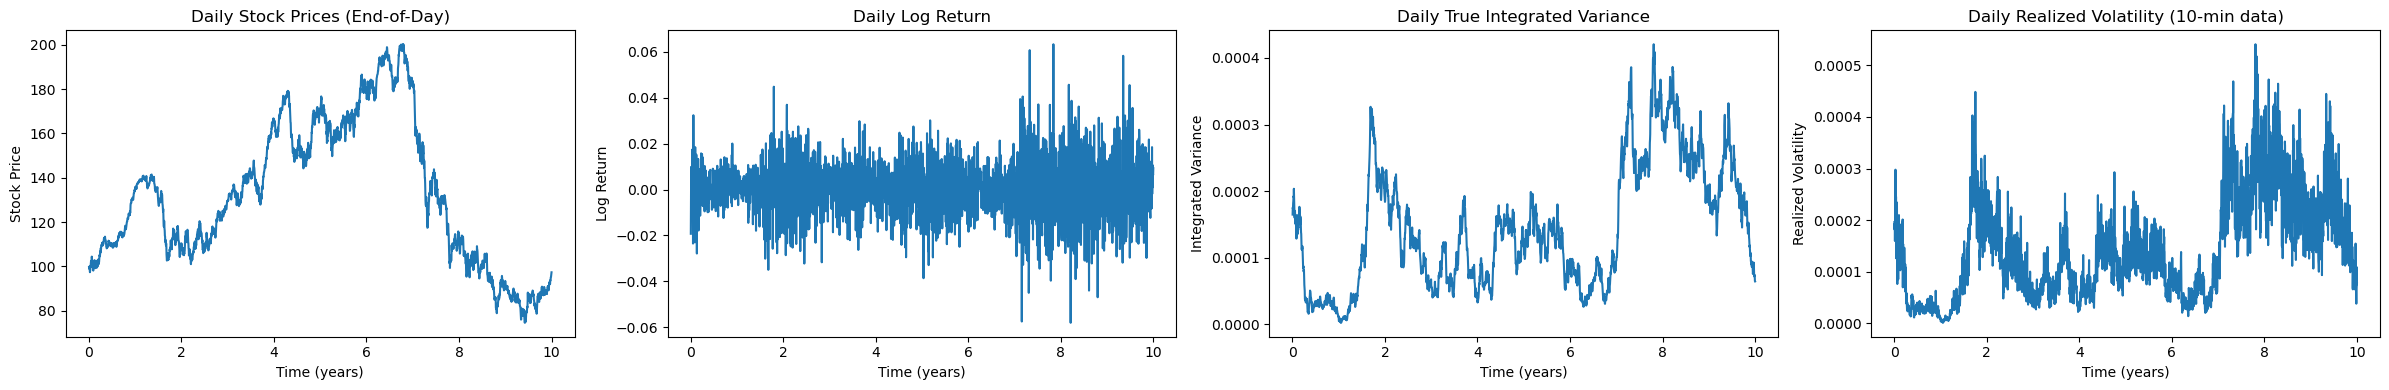

In [2]:
S0 = 100
V0 = 0.04
params = {
    'mu': 0.05, 
    'rho': -0.8,
    'kappa': 1,
    'theta': 0.04,
    'xi': 0.2
}

std_asy = np.sqrt(params['theta'] * params['xi']**2 / (2 * params['kappa']))  # asymptotic standard deviation for the CIR process
assert 2 * params['kappa'] * params['theta'] > params['xi']**2  # Feller condition

Hest = Heston(**params)
time_daily, S_daily, daily_returns, daily_true_V, daily_RV = Hest.path_simulation(S0, V0, T_years=10, trading_days=252, intraday_intervals=39, seed=10)
R_daily = np.diff(np.log(S_daily))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 4))

ax1.plot(time_daily, S_daily)
ax1.set_title("Daily Stock Prices (End-of-Day)")
ax1.set_xlabel("Time (years)")
ax1.set_ylabel("Stock Price")

ax2.plot(time_daily, daily_returns)
ax2.set_title("Daily Log Return")
ax2.set_xlabel("Time (years)")
ax2.set_ylabel("Log Return")

ax3.plot(time_daily, daily_true_V)
ax3.set_title("Daily True Integrated Variance")
ax3.set_xlabel("Time (years)")
ax3.set_ylabel("Integrated Variance")

ax4.plot(time_daily, daily_RV)
ax4.set_title("Daily Realized Volatility (10-min data)")
ax4.set_xlabel("Time (years)")
ax4.set_ylabel("Realized Volatility")

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
from scipy.optimize import minimize

def KF_Heston(kappa, theta, mu, sigma, xi, dt, R, RV, V0, P0):
    """
    Kalman filter implementation for a Heston model with 2D measurements.
    
    Parameters:
    -----------
    kappa : float
        Mean reversion rate.
    theta : float
        Long-term variance.
    mu : float
        Drift parameter.
    sigma : float
        Volatility of volatility.
    xi : float
        Process noise scaling parameter.
    dt : float
        Time interval.
    R : numpy.ndarray
        Returns data, shape (T,).
    RV : numpy.ndarray
        Realized variance data, shape (T,).
    V0 : float
        Initial variance estimate.
    P0 : float
        Initial estimation error variance.
    
    Returns:
    --------
    V_filt : numpy.ndarray
        Filtered (updated) variance estimates (T,).
    P_filt : numpy.ndarray
        Filtered state covariance (T,).
    V_pred : numpy.ndarray
        Predicted state (variance) estimates (T,).
    P_pred : numpy.ndarray
        Predicted state covariance (T,).
    """
    T = len(R)
    # Stack returns and realized variance into a T x 2 observation matrix.
    y = np.column_stack((R, RV))  # shape: (T, 2)
    
    # Define measurement model parameters (2x1 vectors)
    beta = np.array([[-0.5 * dt], [dt]])    # shape: (2,1)
    mu_vec = np.array([[mu * dt], [0]])       # shape: (2,1)
    sigma_vec = np.array([[np.sqrt(dt)], [sigma * np.sqrt(dt)]])  # shape: (2,1)
    
    # Pre-allocate arrays (scalar state)
    V_pred = np.zeros(T)  # Predicted variance estimates
    P_pred = np.zeros(T)  # Predicted state covariance (scalar)
    V_filt = np.zeros(T)  # Filtered variance estimates
    P_filt = np.zeros(T)  # Filtered state covariance (scalar)
    
    # Initial conditions at t = 0
    V_filt_prev = V0
    P_filt_prev = P0
    
    for t in range(T):
        # ----- Prediction Step -----
        # Use Euler discretization: V_pred = V_filt_prev + kappa*(theta - V_filt_prev)*dt
        V_pred[t] = V_filt_prev + kappa * (theta - V_filt_prev) * dt
        # Process noise variance Q, scaled with dt.
        Q = xi**2 * V_filt_prev * dt
        # Propagate variance: P_pred = (1 - kappa*dt)^2 * P_filt_prev + Q
        P_pred[t] = (1 - kappa * dt)**2 * P_filt_prev + Q
        
        # ----- Measurement Update Step -----
        # Predicted measurement: y_pred = mu_vec + beta * V_pred[t]  (2x1 vector)
        y_pred = mu_vec + beta * V_pred[t]
        # Innovation (measurement residual): observed y (reshaped to 2x1) minus predicted y.
        innovation = y[t].reshape(2, 1) - y_pred
        
        # Measurement noise covariance R_mat, "freezing" the variance at V_pred[t]:
        scaled_sigma_vec = sigma_vec * np.sqrt(V_pred[t])
        epsilon = 1e-6  # or another small positive number
        R_mat = scaled_sigma_vec @ scaled_sigma_vec.T + epsilon * np.eye(2)
        R_mat = (R_mat + R_mat.T) / 2  # Ensure symmetry
        
        # Innovation covariance S: S = beta * P_pred[t] * beta^T + R_mat  (2x2)
        S = P_pred[t] * (beta @ beta.T) + R_mat
        S = (S + S.T) / 2  # Ensure symmetry
        
        # Kalman Gain: K = P_pred[t] * beta^T * inv(S) (1x2 vector)
        K = P_pred[t] * beta.T @ np.linalg.inv(S)
        
        # Update state estimate with innovation:
        V_filt[t] = V_pred[t] + (K @ innovation).item()
        # Update state covariance:
        P_filt[t] = (1 - (K @ beta).item()) * P_pred[t]
        
        # Ensure non-negative variance
        V_filt[t] = max(V_filt[t], 1e-6)
        
        # Update for next iteration:
        V_filt_prev = V_filt[t]
        P_filt_prev = P_filt[t]
    
    return V_filt, P_filt, V_pred, P_pred


def NegativeLogLikelihood_Heston(params, R, RV, dt):
    """
    Negative log-likelihood function for the Heston model.
    
    Parameters:
    -----------
    params : numpy.ndarray
        Model parameters [kappa, theta, mu, sigma, xi].
    R : numpy.ndarray
        Returns data, shape (T,).
    RV : numpy.ndarray
        Realized variance data, shape (T,).
    dt : float
        Time interval.
    
    Returns:
    --------
    nll : float
        Negative log-likelihood.
    """
    # Extract parameters
    kappa, theta, mu, sigma, xi = params
    if kappa <= 0 or theta <= 0 or sigma <= 0:
        return np.inf
    
    # Initial conditions for the Kalman filter
    V0 = theta  # Initial variance estimate (can be set to the long-term variance)
    P0 = theta  # Initial estimation error variance
    
    # Run the Kalman filter
    V_filt, _, V_pred, _ = KF_Heston(kappa, theta, mu, sigma, xi, dt, R, RV, V0, P0)
    
    # Define measurement model parameters
    beta = np.array([[-0.5 * dt], [dt]])    # 2x1 vector
    mu_vec = np.array([[mu * dt], [0]])       # 2x1 vector
    sigma_vec = np.array([[np.sqrt(dt)], [sigma * np.sqrt(dt)]])  # 2x1 vector
    
    T = len(R)
    LL = np.zeros(T)
    
    for t in range(1,T):
        # Measurement prediction: y_pred = mu_vec + beta * V_pred[t]
        y_pred = mu_vec + beta * V_pred[t]
        # Compute measurement noise covariance using the "frozen" predicted variance:
        scaled_sigma_vec = sigma_vec * np.sqrt(V_filt[t-1])
        epsilon = 1e-6  # or another small positive number
        R_mat = scaled_sigma_vec @ scaled_sigma_vec.T + epsilon * np.eye(2)
        R_mat = (R_mat + R_mat.T) / 2
        
        # Innovation: difference between observed y (reshaped to 2x1) and y_pred.
        innovation = np.array([R[t], RV[t]]).reshape(2, 1) - y_pred
        
        # Multivariate Gaussian log-likelihood for the measurement:
        det_R = np.linalg.det(2 * np.pi * R_mat)
        inv_R = np.linalg.inv(R_mat)
        LL[t] = -0.5 * np.log(det_R) - 0.5 * (innovation.T @ inv_R @ innovation).item()
    
    nll = -np.sum(LL)
    return nll


def QMLE_Heston(R, RV, dt, initial_params=None):
    """
    Quasi-Maximum Likelihood Estimation (QMLE) for the Heston model.
    
    Parameters:
    -----------
    R : numpy.ndarray
        Returns data, shape (T,).
    RV : numpy.ndarray
        Realized variance data, shape (T,).
    dt : float
        Time interval.
    initial_params : numpy.ndarray, optional
        Initial parameter values [kappa, theta, mu, sigma, xi].
        
    Returns:
    --------
    params_opt : numpy.ndarray
        Optimized parameters [kappa, theta, mu, sigma, xi].
    nll_opt : float
        Negative log-likelihood at the optimum.
    """
    # Provide default initial parameters if none are supplied
    if initial_params is None:
        kappa_init = 5.0
        theta_init = np.mean(RV)
        mu_init = np.mean(R) / dt
        sigma_init = 0.5
        xi_init = 0.5
        initial_params = np.array([kappa_init, theta_init, mu_init, sigma_init, xi_init])
    
    # Parameter bounds to ensure stability and positiveness where required
    bounds = [
        (1e-6, 20.0),   # kappa
        (1e-6, 1.0),    # theta
        (-1.0, 1.0),    # mu
        (1e-6, 2.0),    # sigma
        (1e-6, 3.0)     # xi
    ]
    
    # Optimize the negative log-likelihood using L-BFGS-B
    result = minimize(
        fun=NegativeLogLikelihood_Heston,
        x0=initial_params,
        args=(R, RV, dt),
        bounds=bounds,
        method='L-BFGS-B'
    )
    
    params_opt = result.x
    nll_opt = result.fun
    
    # Display the results
    param_names = ['kappa', 'theta', 'mu', 'sigma', 'xi']
    print("QMLE Results for Heston Model:")
    print("-" * 50)
    for i, name in enumerate(param_names):
        print(f"{name}: {params_opt[i]:.6f}")
    print(f"Negative Log-Likelihood: {nll_opt:.6f}")
    print(f"Convergence: {result.success}")
    if not result.success:
        print(f"Message: {result.message}")
    print("-" * 50)
    
    return params_opt, nll_opt

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

S0 = 100
V0 = 0.04

params = {
    'mu': 0.05,      
    'rho': -0.8,     
    'kappa': 1.0,    
    'theta': 0.04,   
    'xi': 0.2        
}

std_asy = np.sqrt(params['theta'] * params['xi']**2 / (2 * params['kappa']))
assert 2 * params['kappa'] * params['theta'] > params['xi']**2, "Feller condition is violated!"

Hest = Heston(**params)
time_daily, S_daily, daily_returns, daily_true_V, daily_RV = Hest.path_simulation(S0, V0, T_years=10, trading_days=252, intraday_intervals=39, seed=10)

R_daily = daily_returns.copy()

dt = 1
burnin = 100

initial_params = np.array([0.08, 0.004, -0.0001, 0.01, 0.5])

# Call the QMLE function to estimate the parameters.
# QMLE_Heston returns a tuple: (params_opt, nll_opt)
params_opt, nll_opt = QMLE_Heston(R_daily[burnin:], daily_RV[burnin:], dt, initial_params=initial_params)
print("Optimized parameters:", params_opt)

# ----------------------------------------------------------------------
# (3) Run the Kalman Filter with the Estimated Parameters
# ----------------------------------------------------------------------
# Unpack the estimated parameters.
kappa_est, theta_est, mu_est, sigma_est, xi_est = params_opt

# For the filter, we set the initial variance estimates equal to the long-term variance.
V0_est = theta_est  
P0_est = theta_est  

# Run the Kalman filter. Note: our function KF_Heston returns
# (V_filt, P_filt, V_pred, P_pred), where the state is scalar.
V_filt, P_filt, V_pred, P_pred = KF_Heston(kappa_est, theta_est, mu_est, sigma_est, xi_est, dt, R_daily, daily_RV, V0_est, P0_est)

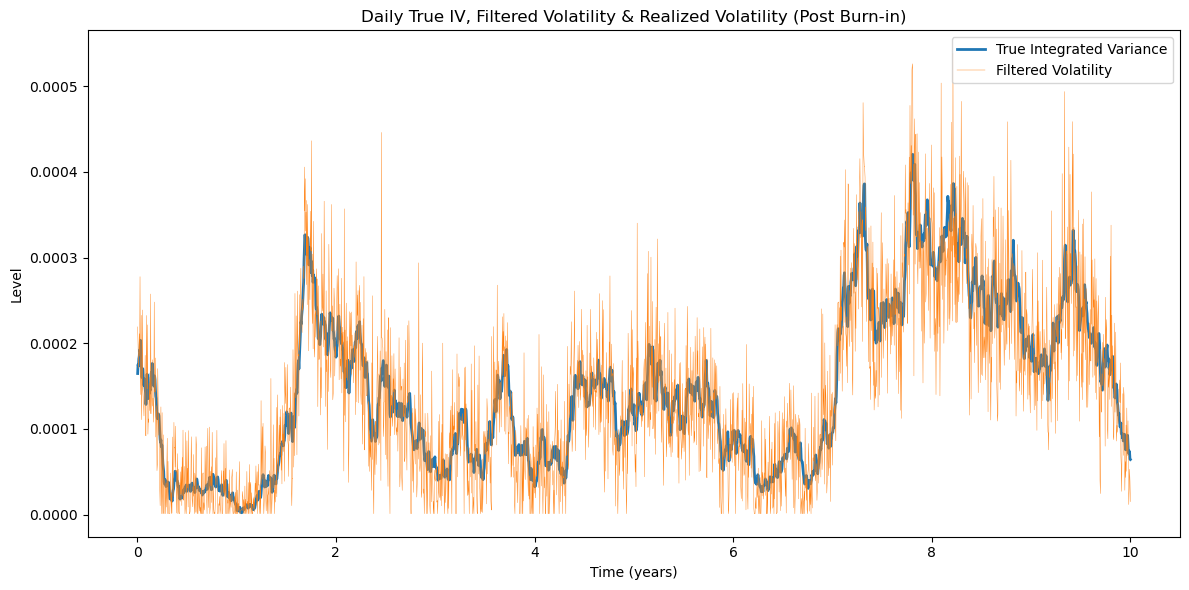

RMSE (Filtered vs True): 0.000053
RMSE (Realized vs True): 0.000038


In [43]:
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the True Integrated Variance.
ax.plot(time_daily, daily_true_V, label="True Integrated Variance", lw=2)
# Plot the Filtered Variance (interpreted as volatility here).
ax.plot(time_daily, V_filt, label="Filtered Volatility", lw=0.3)
# Plot the Realized Volatility.
# ax.plot(time_daily, daily_RV, label="Realized Volatility", lw=0.3, linestyle='--')

ax.set_title("Daily True IV, Filtered Volatility & Realized Volatility (Post Burn-in)")
ax.set_xlabel("Time (years)")
ax.set_ylabel("Level")
ax.legend(loc="upper right")
plt.tight_layout()
plt.show()

# Compute and display RMSEs (Root Mean Squared Errors) between True and estimated series.
true_post = daily_true_V[burnin:]
filt_post = V_filt[burnin:]
rv_post = daily_RV[burnin:]

rmse_filt = np.sqrt(np.mean((true_post - filt_post)**2))
rmse_rv = np.sqrt(np.mean((true_post - rv_post)**2))

print(f"RMSE (Filtered vs True): {rmse_filt:.6f}")
print(f"RMSE (Realized vs True): {rmse_rv:.6f}")

In [27]:
HestonKF_RV = HestonKF(y=daily_RV, V0=0.01, P0=0.1)

init_guess = np.array([1, 0.05, 0.5, 0.5]) # kappa, theta, xi, sigma
bounds = [
    (1e-8, 1 - 1e-8),  # 0 <= kappa <= 1
    (1e-8, None),      # theta >= 0
    (1e-8, None),      # xi >= 0
    (1e-8, None)       # sigma >= 0
]

result_rv = HestonKF_RV.estimate_params(option='rv', init_params=init_guess, bounds=bounds)

In [25]:
HestonKF_rtn = HestonKF(y=daily_returns, V0=0.01, P0=0.1)

init_guess = np.array([0.5, 0.5, 0.5, 0]) # kappa, theta, xi, mu
bounds = [
    (1e-8, 1 - 1e-8),  # 0 <= kappa <= 1
    (1e-8, None),      # theta >= 0
    (1e-8, None),      # xi >= 0
    (1e-8, None)       # mu
]

result_rtn = HestonKF_rtn.estimate_params(option='return', init_params=init_guess, bounds=bounds)

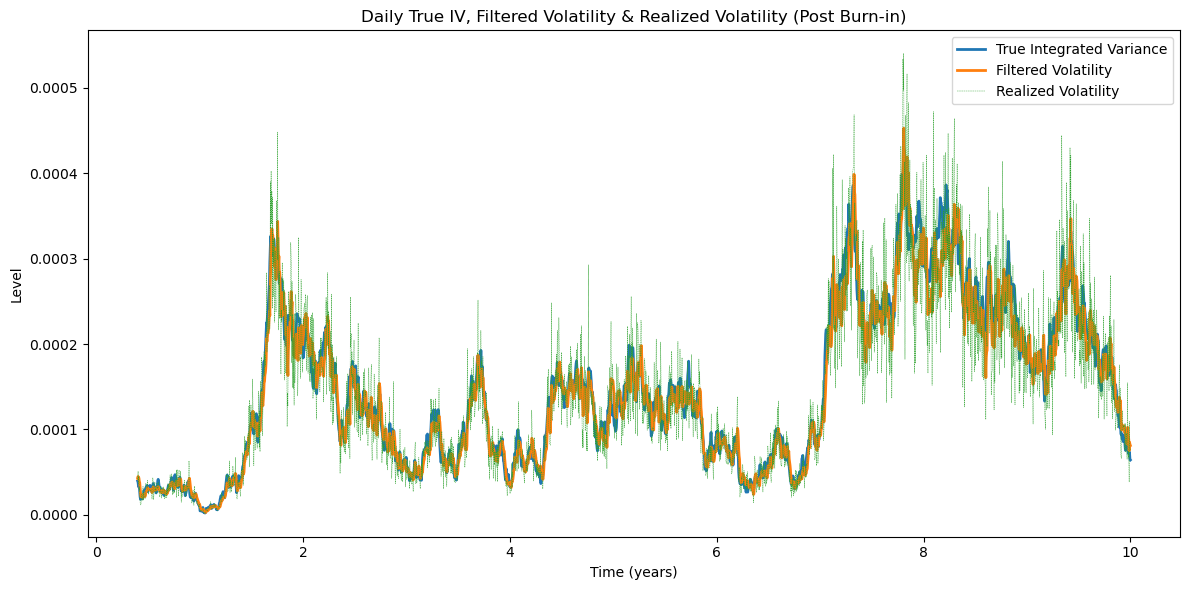

RMSE (Filtered vs True): 0.000019
RMSE (Realized vs True): 0.000038


In [29]:
# V_pred, P_pred, V_filt, P_filt = HestonKF_rtn.kalman_filter_Return(result_rtn.x)
V_pred, P_pred, V_filt, P_filt = HestonKF_RV.kalman_filter_RV(result_rv.x)

burnin = 100

fig, ax = plt.subplots(figsize=(12, 6))

# Plotting True Integrated Variance
ax.plot(time_daily[burnin:], daily_true_V[burnin:], label="True Integrated Variance", lw=2)

# Plotting Filtered Volatility
ax.plot(time_daily[burnin:], V_filt[burnin:], label="Filtered Volatility", lw=2)

# Plotting Realized Volatility
ax.plot(time_daily[burnin:], daily_RV[burnin:], label="Realized Volatility", lw=0.3, linestyle='--')

ax.set_title("Daily True IV, Filtered Volatility & Realized Volatility (Post Burn-in)")
ax.set_xlabel("Time (years)")
ax.set_ylabel("Level")
ax.legend(loc="upper right")
plt.tight_layout()
plt.show()

true_post = daily_true_V[burnin:]
filt_post = V_filt[burnin:]
rv_post = daily_RV[burnin:]

# Compute RMSEs
rmse_filt = np.sqrt(np.mean((true_post - filt_post) ** 2))
rmse_rv = np.sqrt(np.mean((true_post - rv_post) ** 2))

print(f"RMSE (Filtered vs True): {rmse_filt:.6f}")
print(f"RMSE (Realized vs True): {rmse_rv:.6f}")

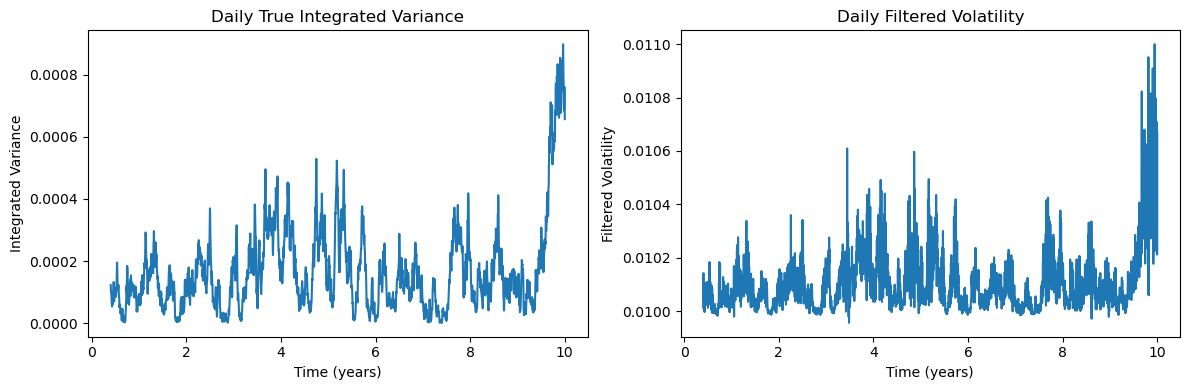

In [21]:
params_1d = [mu, kappa, theta, xi, 1]

V_pred, P_pred, V_filt, P_filt = kalman_like_heston_filter(params_1d, RV, true_variance[0], 0.07)

# Create two subplots: one for True Integrated Variance and one for Filtered Volatility.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

time = time_daily[1:]
burnin = 100

# Plot Daily True Integrated Variance
ax1.plot(time[burnin:], true_variance[burnin:])
ax1.set_title("Daily True Integrated Variance")
ax1.set_xlabel("Time (years)")
ax1.set_ylabel("Integrated Variance")

# Plot Daily Filtered Volatility (corrected from ax3 to ax2)
ax2.plot(time[burnin:], V_filt[burnin:])
ax2.set_title("Daily Filtered Volatility")
ax2.set_xlabel("Time (years)")
ax2.set_ylabel("Filtered Volatility")

plt.tight_layout()
plt.show()

In [ ]:
[0.00153758 0.00022155 0.00240157 0.002842  ]

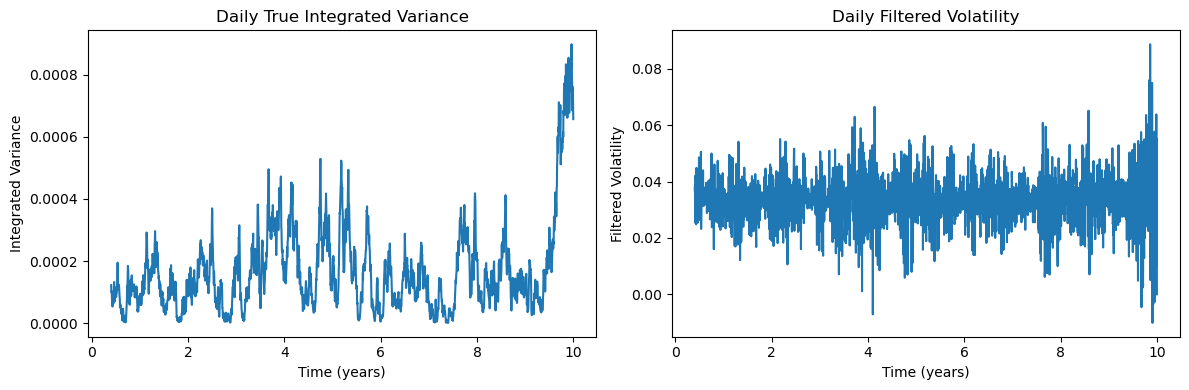

In [24]:
params_2d = [mu, kappa, theta, xi, 1, rho, 0]

# Apply the Kalman-like Heston filter function
V_pred, P_pred, V_filt, P_filt = kalman_like_heston_filter_2d(params=params_2d, R=R, RV=RV, V0=0, P0=0.1)

time = time_daily[1:]
burnin = 100

# Create two subplots: one for True Integrated Variance and one for Filtered Volatility.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot Daily True Integrated Variance
ax1.plot(time[burnin:], true_variance[burnin:])
ax1.set_title("Daily True Integrated Variance")
ax1.set_xlabel("Time (years)")
ax1.set_ylabel("Integrated Variance")

# Plot Daily Filtered Volatility (corrected from ax3 to ax2)
ax2.plot(time[burnin:], V_filt[burnin:])
ax2.set_title("Daily Filtered Volatility")
ax2.set_xlabel("Time (years)")
ax2.set_ylabel("Filtered Volatility")

plt.tight_layout()
plt.show()


In [8]:
V_filt

array([0.01752599, 0.03291151, 0.01961307, ..., 0.01027154, 0.0550855 ,
       0.        ])

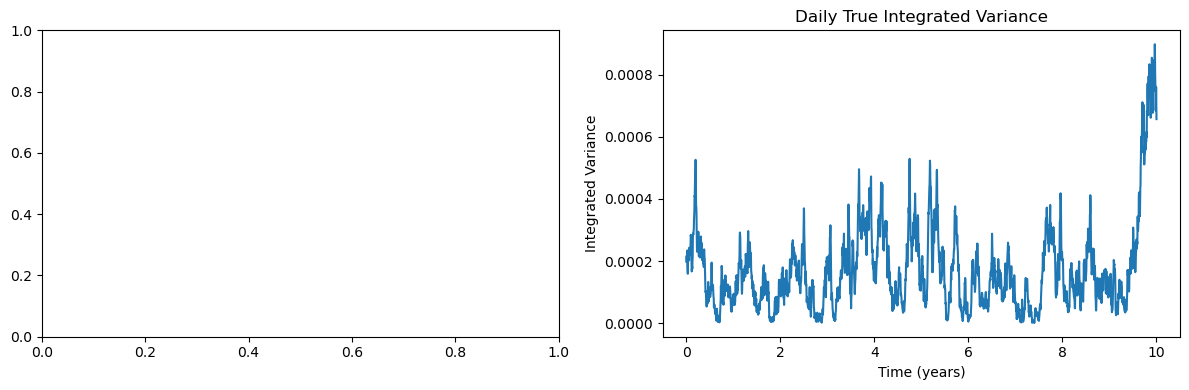